<a href="https://colab.research.google.com/github/aristosp/aristosp/blob/main/tram_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Dependencies
import os
import zipfile
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Dropout, Conv2D, Input, Rescaling, GlobalMaxPool2D, Flatten
import csv
import re
import skimage.io
import librosa
import soundfile
from pathlib import Path

In [2]:
local_zip = '/content/drive/MyDrive/Tram Demo.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
# Create csv file of image directory and corresponding label
def sorted_natural(data):
    """
    This function sorts its input naturally instead of alphabetically
    :param data: Input to be sorted
    :return: it's input, sorted naturally
    """
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


def csv_creator(filename, fields, rows):
    """
    This function creates a csv file, filling it with the contents of fields and rows
    :param filename: Path and name to save the created file
    :param fields: Data to fill the fields of the csv file
    :param rows: Data to fill the rows of the csv file
    :return: Null
    """
    with open(filename, 'w', newline='') as csvfile:
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)
        # writing the fields
        csvwriter.writerow(fields)
        # writing the data rows
        csvwriter.writerows(rows)


def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

In [4]:
def audio_split(file, filename, savelocation, sr, segment_len):
    # split audio sample when the sample is larger than 3 seconds
    y, _ = librosa.load(file, sr=sr)
    duration_in_sec =int(librosa.get_duration(y=y))
    segment_duration = int(segment_len * len(y) / duration_in_sec)
    for sec in range(0, duration_in_sec, segment_len):
        final_loc = savelocation + '/' + str(sec) + '_' + filename
        if sec == 0:
            t1 = sec * segment_duration
            t2 = t1 + segment_duration
            split_audio = y[t1:t2]
            soundfile.write(final_loc,split_audio, samplerate=sr)
        else:
            t1 = previous_t2
            t2 = t1 + segment_duration
            split_audio = y[t1:t2]
            soundfile.write(final_loc, split_audio, samplerate=sr)
        previous_t2 = t2

In [5]:
path = Path('/content/Tram Demo')
train_path = '/content/Tram Demo/dataset/'

In [6]:
# Sort with natural order the labels
labels = sorted_natural(os.listdir(train_path))

In [7]:
# Create new directories to save spectrogram images
folder = '/content/Tram Demo/test_files/'
for og_name in os.listdir(folder):
    os.makedirs(os.path.join('TramDemo_spec_test/testfiles/', og_name))
for og_name in os.listdir('/content/TramDemo_spec_test/testfiles'):
    os.makedirs(os.path.join('/content/TramDemo_spec_test/specfiles/', og_name))
for subfolder_name in labels:
    os.makedirs(os.path.join('TramDemo_spec', subfolder_name))

In [8]:
# Split test files into 3 second samples
for filename in os.listdir(folder):
    saveloc = '/content/TramDemo_spec_test/testfiles/' + filename
    filepath = folder + '/' + filename
    audio_split(filepath, filename, saveloc, 22050, 3)

In [9]:
# settings for the spectrograms
hop_length = 500 # number of samples per time-step in spectrogram
n_mels = 128 # number of bins in spectrogram. Height of image
time_steps = 384 # number of time-steps. Width of image
newfolder = '/content/TramDemo_spec_test/testfiles/'
for og_file in os.listdir(newfolder):
  for filename in os.listdir(newfolder + og_file):
    # Load waveform
    y, sr = librosa.load(newfolder + og_file + '/'+ filename, sr=22050)
    # Write to path
    savepath = '../content/TramDemo_spec_test/specfiles/' + og_file +'/' + filename + '.png'
    spectrogram_image(y, sr=sr, out=savepath, hop_length=hop_length, n_mels=n_mels)

In [10]:
# Create appropriate list to fill training csv file
sample_paths = []
for j in range(len(labels)):
  for i in os.listdir(train_path + labels[j]):
    sample_paths.append(labels[j] + '/' + i)
data_paths = []
for i in sample_paths:
  data_paths.append(train_path + i)

In [11]:
train_rows = []
filepaths = []
for i in range(len(data_paths)):
    for j in labels:
      if j in data_paths[i]:
        train_rows.append([data_paths[i] , j])

In [12]:
# Save csv file
csv_creator('train.csv', ['Filepath', 'label'], train_rows)
# Read csv file
train_df = pd.read_csv('train.csv')
train_df.head()

,Filepath,label
0,/content/Tram Demo/dataset/accelerating_1_New/...,accelerating_1_New
1,/content/Tram Demo/dataset/accelerating_1_New/...,accelerating_1_New
2,/content/Tram Demo/dataset/accelerating_1_New/...,accelerating_1_New
3,/content/Tram Demo/dataset/accelerating_1_New/...,accelerating_1_New
4,/content/Tram Demo/dataset/accelerating_1_New/...,accelerating_1_New


In [17]:
# settings for the spectrograms

for filename in train_df['Filepath']:
    # Load waveform
    y, sr = librosa.load(filename, sr=22050)
    for i in labels:
      if i in filename:
        # Write to work
        path = '../content/TramDemo_spec/'
        newname = filename.replace(train_path, "")
        newname = newname.replace(".wav", ".png")
        savepath = path + newname
        # Create and save spectrogram
        spectrogram_image(y, sr=sr, out=savepath, hop_length=hop_length, n_mels=n_mels)

In [18]:
# create train csv
rows = []
for label in labels:
  for spec in os.listdir('TramDemo_spec/' + label):
      rows.append([path + label + '/' + spec, label])
csv_creator('train_spec.csv', ['Filepath', 'label'], rows)
train_df_spec = pd.read_csv('train_spec.csv')

In [19]:
# get x,y size of image using a random sample
sample = plt.imread(train_df_spec['Filepath'][0])
x_size, y_size = np.shape(sample)
batch = 32 # batch size

In [20]:
# Load spectrogram files
train_ds = tf.keras.utils.image_dataset_from_directory(
                              path,
                              validation_split=0.2,
                              subset="training",
                              seed=123,
                              image_size=(x_size, y_size),
                              color_mode='grayscale',
                              batch_size=batch,
                              shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(
                              path,
                              validation_split=0.2,
                              subset="validation",
                              seed=123,
                              color_mode='grayscale',
                              image_size=(x_size, y_size),
                              batch_size=batch,
                              shuffle=True)

Found 2168 files belonging to 8 classes.
Using 1735 files for training.
Found 2168 files belonging to 8 classes.
Using 433 files for validation.


In [21]:
# Model layout
num_classes = 8
model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(x_size, y_size, 1)),
  Rescaling(1./255, input_shape=(x_size, y_size, 1)),
  Conv2D(16, 3, activation='leaky_relu' , input_shape=(x_size, y_size, 1)),
  BatchNormalization(),
  Conv2D(32, 3, activation='leaky_relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3,  activation='leaky_relu'),
  BatchNormalization(),
  Dropout(0.2),
  Conv2D(128, 5, activation='leaky_relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Flatten(),
  Dropout(0.2),
  Dense(128, activation='leaky_relu'),
  Dropout(0.2),
  Dense(32, activation='leaky_relu'),
  Dense(num_classes)
])
model.summary()
model.build()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 140, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 138, 16)      160       
                                                                 
 batch_normalization (Batch  (None, 126, 138, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 136, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 68, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 62, 68, 32)        1

In [22]:
callback = []
save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'../content/weights/best_weights.hdf5', save_best_only=True, verbose=1)
callback.append(save_best_callback)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
callback.append(early_stop_callback)

In [23]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
results = model.fit(train_ds, epochs=50,
          validation_data=val_ds,
          batch_size=batch,
          verbose=1 , callbacks=callback)

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.7712
Epoch 1: val_loss improved from inf to 3.69166, saving model to ../content/weights/best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 21s 105ms/step - loss: 0.7935 - accuracy: 0.7712 - val_loss: 3.6917 - val_accuracy: 0.0624
Epoch 2/50
54/55 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9728
Epoch 2: val_loss did not improve from 3.69166
55/55 [==============================] - 4s 79ms/step - loss: 0.1031 - accuracy: 0.9729 - val_loss: 7.3624 - val_accuracy: 0.0624
Epoch 3/50
54/55 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9931
Epoch 3: val_loss did not improve from 3.69166
55/55 [==============================] - 4s 69ms/step - loss: 0.0234 - accuracy: 0.9931 - val_loss: 8.8412 - val_accuracy: 0.0624
Epoch 4/50
54/55 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959
Epoch 4: val_loss did not improve from 3.69166
55/55 [==============================] - 4s 69ms/step - loss: 0.0134 - accuracy: 0.9954 - val_loss: 8.2730 - val_accuracy: 0.0162
Epoch 5/50
54/55 [============================>.] - ETA

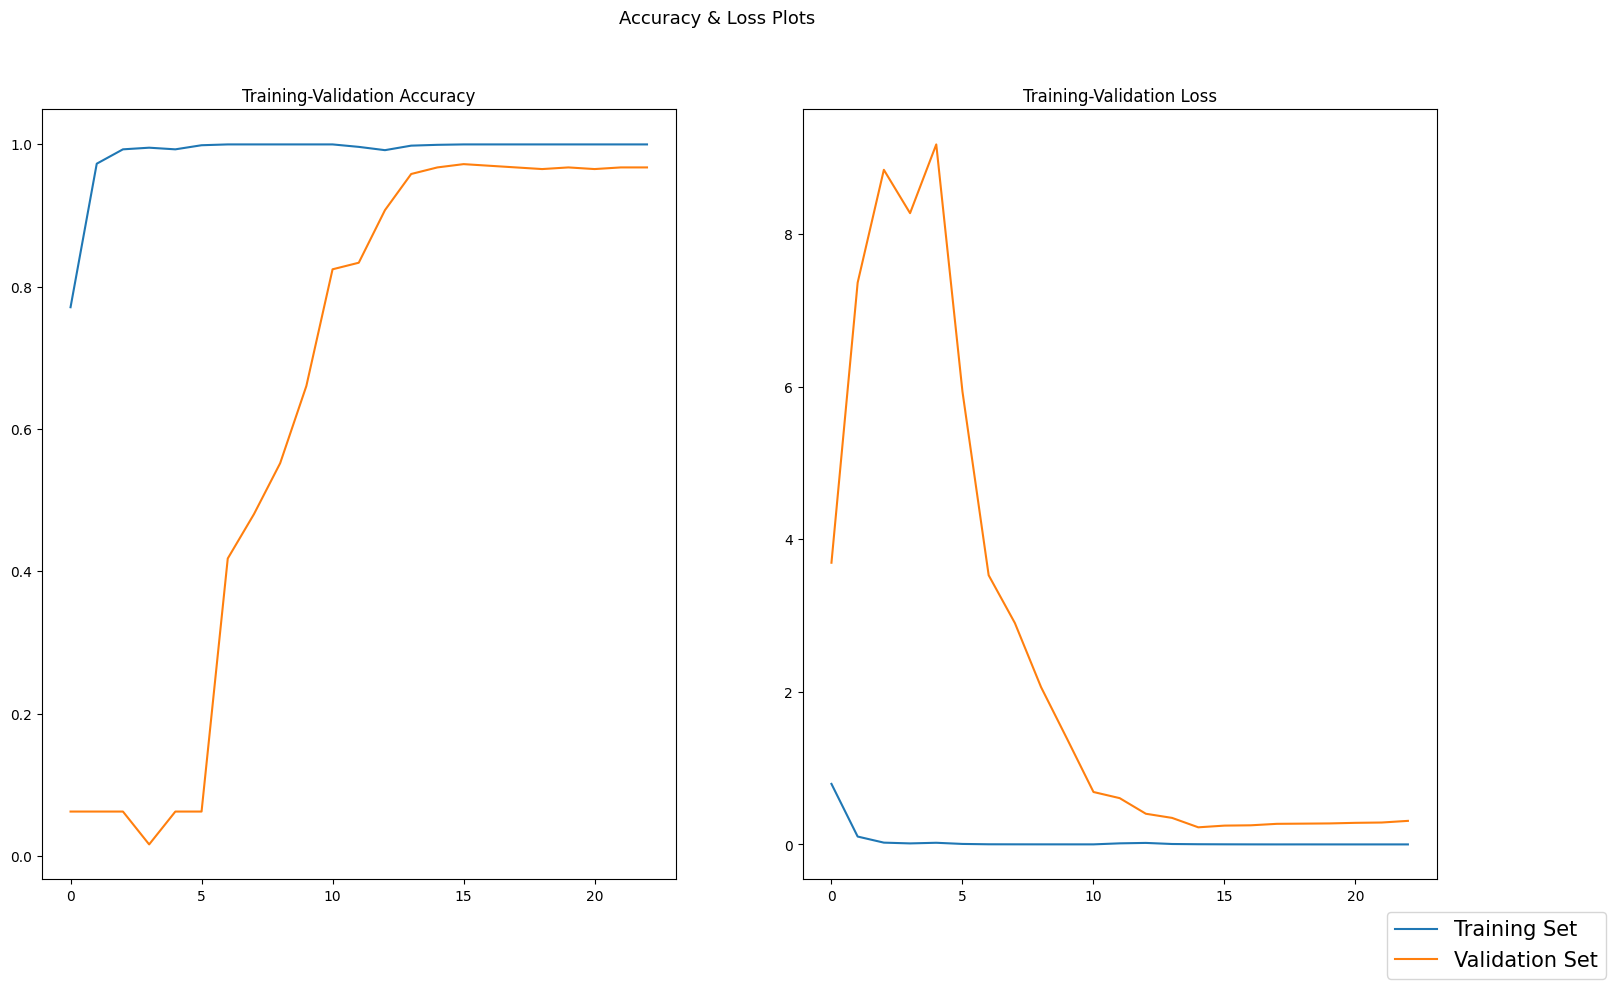

In [25]:
# Review training with the following plots
# Plot Metrics
fig, axs = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Accuracy & Loss Plots', fontsize=13)
axs[0].plot(results.history['accuracy'])
axs[0].plot(results.history['val_accuracy'])
axs[0].set_title('Training-Validation Accuracy', fontsize=12)
axs[1].plot(results.history['loss'])
axs[1].plot(results.history['val_loss'])
axs[1].set_title('Training-Validation Loss', fontsize=12)
fig.legend(['Training Set', 'Validation Set'], loc='lower right', fontsize=15)
plt.show()

In [26]:
# test samples
test_path = '/content/TramDemo_spec_test/specfiles/'
test_ds = tf.keras.utils.image_dataset_from_directory(
                              test_path,
                              seed=123,
                              labels = None,
                              color_mode='grayscale',
                              image_size=(x_size, y_size),
                              batch_size=batch,
                              shuffle=False)

Found 500 files belonging to 1 classes.


In [27]:
predictions = model.predict(test_ds, batch_size=batch)

16/16 [==============================] - 1s 45ms/step


In [28]:
score = tf.nn.softmax(predictions)

In [29]:
# Save csv file
csv_list = []
sec_offset = 0
for i in range(len(score)):
  row = [0, 0, 0, 0, 0, 0, 0, 0, 0]
  class_idx = np.argmax(score[i])
  sec_offset += 3 # due to the samples being 3 second long each
  if sec_offset == 300:
    sec_offset = 0
  row[0] = sec_offset
  row[class_idx + 1] = 1
  csv_list.append(row)
csv_creator('predictions.csv', ['seconds_offset', 'accelerating_1_New','accelerating_2_CKD_Long','accelerating_3_CKD_Short',
                                'accelerating_4_Old','braking_1_New','braking_2_CKD_Long','braking_3_CKD_Short','braking_4_Old'], csv_list)
